<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Note: this is only a draft of a homework, the final Notebook will be released soon

In [ ]:
!pip install pmdarima
!pip install git+https://github.com/pydata/pandas-datareader.git

     |████████████████████████████████| 1.4 MB 8.3 MB/s 
     |████████████████████████████████| 9.8 MB 48.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the trend 
# of the pair NZDJPY pair using the pair's prince history
#Import the libraries
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import pandas_datareader as web
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
symbol = "EURUSD=X"
data = web.DataReader(symbol, data_source='yahoo', start='2019-01-01', end='2022-02-01') 
data.append(pd.DataFrame({'date': pd.date_range(start=df.date.iloc[-1], periods= 4, freq='d', closed='right')}))
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,1.296395,1.292257,1.296008,1.296008,0.0,1.296008
2012-01-03,1.306592,1.293628,1.293628,1.294096,0.0,1.294096
2012-01-04,1.307395,1.290206,1.305398,1.305602,0.0,1.305602
2012-01-05,1.294297,1.278527,1.293092,1.293142,0.0,1.293142
2012-01-06,1.281296,1.270406,1.279296,1.279607,0.0,1.279607


In [ ]:
data.shape

(2605, 6)

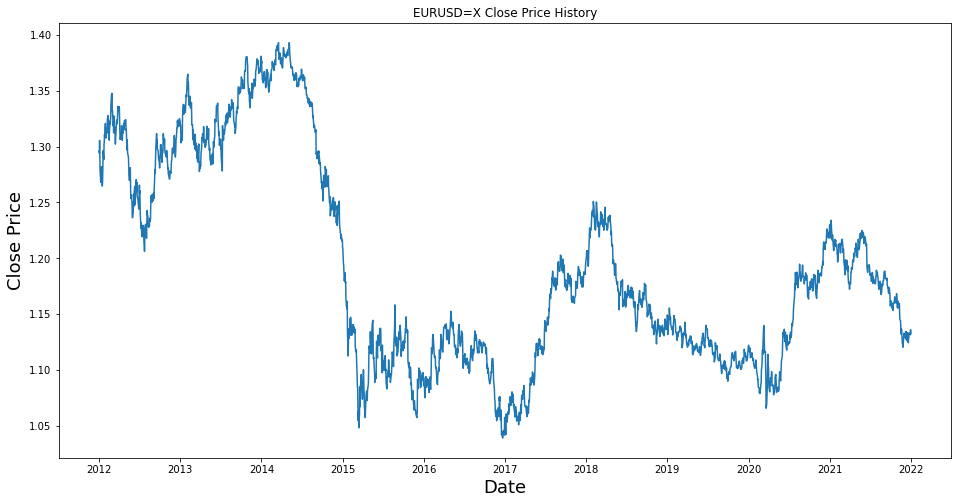

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('{symbol} Close Price History'.format(symbol = symbol))
plt.plot(data['Adj Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [ ]:
# Initialize the short and long windows
short_window = 22 # <-- a month
long_window = 66 # <-- 3 months
# return threshold for LSTM (0.1 = 10%)
return_threshold = 0.1
# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=data.index)
signals['signal'] = 0.0
# Create short simple moving average over the short window
signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
# Create long simple moving average over the long window
signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   
# Generate trading orders
signals['positions'] = signals['signal'].diff()
# Print `signals`
print(signals)

            signal  short_mavg  long_mavg  positions
Date                                                
2012-01-02     0.0    1.296008   1.296008        NaN
2012-01-03     0.0    1.295052   1.295052        0.0
2012-01-04     0.0    1.298569   1.298569        0.0
2012-01-05     0.0    1.297212   1.297212        0.0
2012-01-06     0.0    1.293691   1.293691        0.0
...            ...         ...        ...        ...
2021-12-27     0.0    1.129689   1.145813        0.0
2021-12-28     0.0    1.130237   1.145218        0.0
2021-12-29     0.0    1.130335   1.144639        0.0
2021-12-30     0.0    1.130638   1.144145        0.0
2021-12-31     0.0    1.130614   1.143726        0.0

[2605 rows x 4 columns]


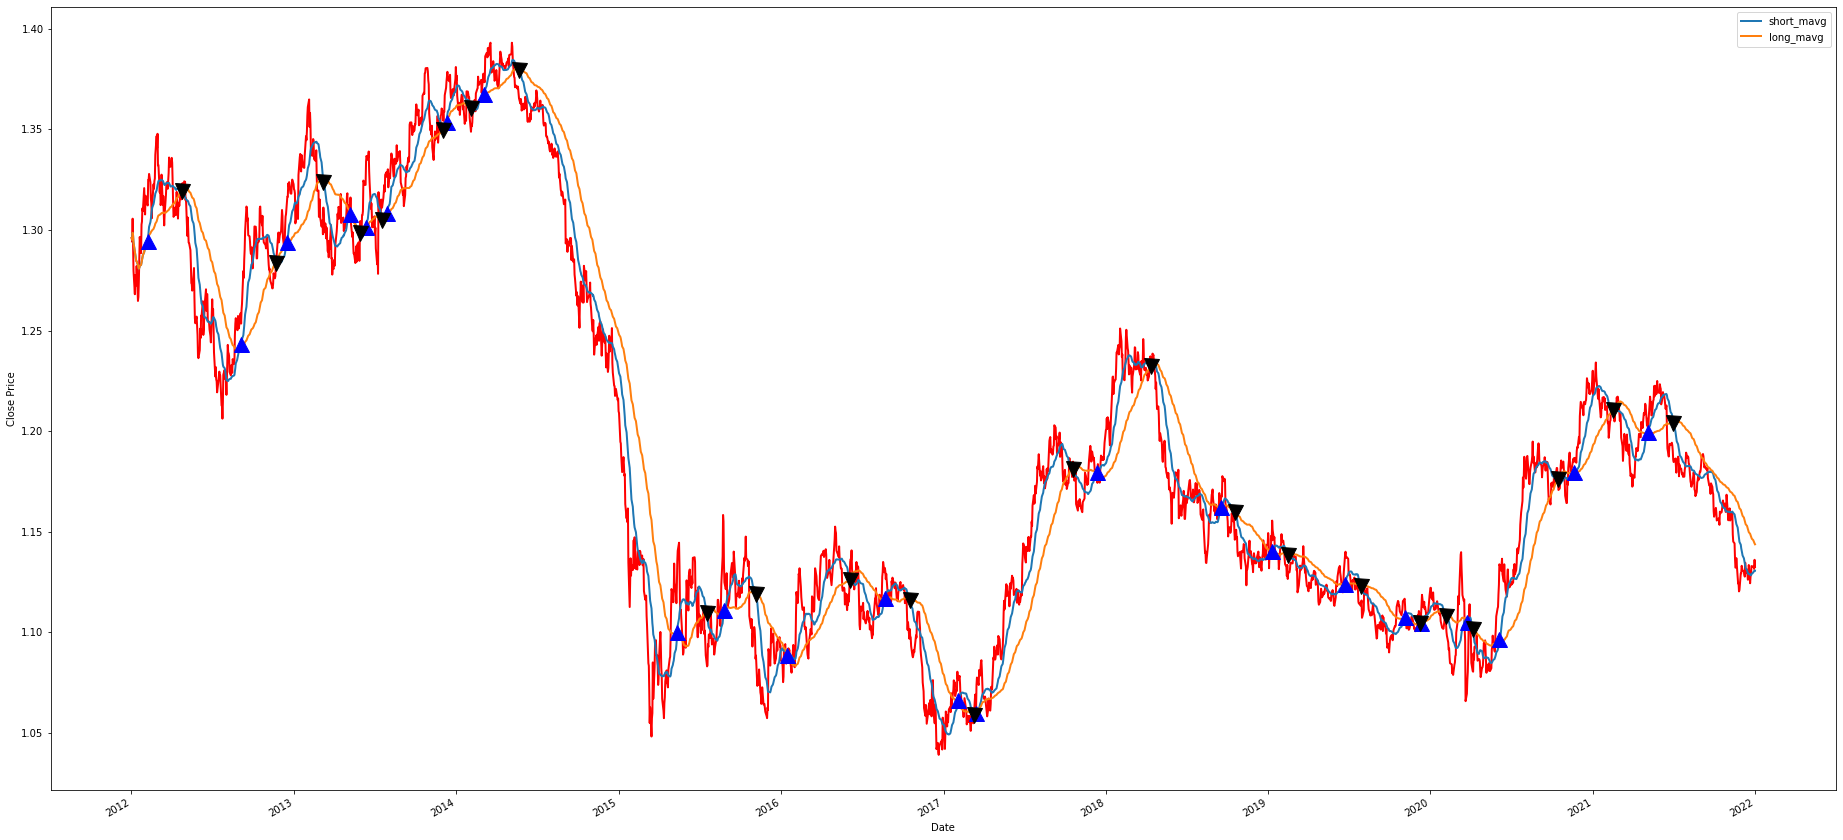

In [ ]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))
# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Close Price')
# Plot the closing price
data['Adj Close'].plot(ax=ax1, color='r', lw=2.)
# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=15, color='b')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=15, color='k')
         
# Show the plot
plt.show()

# Forecast Symbol close prices using a LSTM Model

In [ ]:
#Create a new dataframe with only the 'Close' column
data = data.filter(['Adj Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

# Create the scaled training data set 
train_data = scaled_data[0:training_data_len, : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train =[]

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2024/2024 [==============================] - 65s 30ms/step - loss: 0.0026


In [ ]:
from joblib import dump, load
dump(model, '/content/drive/MyDrive/data/lstm_{symbol}.joblib'.format(symbol=symbol)) 

INFO:tensorflow:Assets written to: ram://b315e88f-5425-4c71-bc03-8fa428b27191/assets


INFO:tensorflow:Assets written to: ram://b315e88f-5425-4c71-bc03-8fa428b27191/assets


['/content/drive/MyDrive/data/lstm_EURUSD=X.joblib']

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
#Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

array([[0.72579585],
       [0.72039568],
       [0.75289471],
       ...,
       [0.26107309],
       [0.27388899],
       [0.26396846]])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [ ]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

0.008093639499760481

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


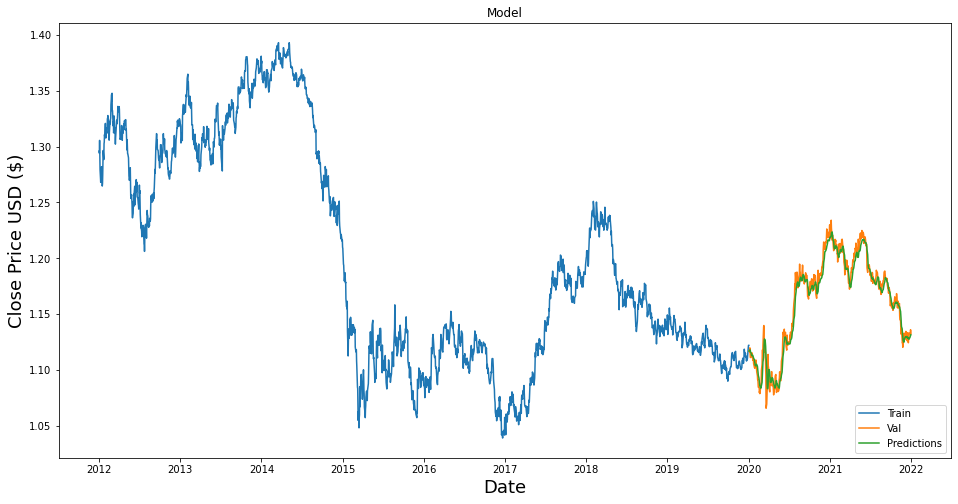

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()